# House Prices: Advanced Regression Techniques

Competition web page: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Influenced by: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

## Description

![image.png](attachment:image.png)

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Goal

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## 1. Setup environment

#### 1.1 Fire up imports

In [65]:
# Trick to install a package in docker container
import pip    
def install(package):
   pip.main(['install', package])

In [66]:
import csv
import operator
import os
import pandas
import re
import sklearn
import string
import numpy as np

# machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
# Comment out if necessary
warnings.simplefilter("ignore", category=RuntimeWarning)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Get to know data

#### 2.1 Read some house data

In [67]:
data_dir = 'data'

train_file = os.path.join(data_dir, 'train.csv')
train_data = pandas.read_csv(train_file)

test_file = os.path.join(data_dir, 'test.csv')
test_data = pandas.read_csv(test_file)

In [68]:
print("train : " + str(train_data.shape))

train : (1460, 81)


In [69]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train_data.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice.head(8))

Find most important features relative to target
SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
Name: SalePrice, dtype: float64


## 3. COMPREHENSIVE DATA EXPLORATION
Taken from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python What we are doing in this kernel is something like:

1. **Understand the problem**. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.

2. **Univariable study**. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.

3. **Multivariate study**. We'll try to understand how the dependent variable and independent variables relate.

4. **Basic cleaning**. We'll clean the dataset and handle the missing data, outliers and categorical variables.

5. **Test assumptions**. We'll check if our data meets the assumptions required by most multivariate techniques.

In [70]:
## TODO: add steps 1-3, 5

#### 3.4 Basic cleaning

In [71]:
# Fill in missing values

# add missing values to train dataset
train_data['GrLivAreaFull'] = train_data.GrLivArea.fillna(train_data.GrLivArea.mean())
train_data['GarageAreaFull'] = train_data.GarageArea.fillna(train_data.GarageArea.mean())
train_data['TotalBsmtSF'] = train_data.TotalBsmtSF.fillna(train_data.TotalBsmtSF.mean())

# add missing values to test dataset
test_data['GrLivAreaFull'] = test_data.GrLivArea.fillna(test_data.GrLivArea.mean())
test_data['GarageAreaFull'] = test_data.GarageArea.fillna(test_data.GarageArea.mean())
test_data['TotalBsmtSF'] = test_data.TotalBsmtSF.fillna(test_data.TotalBsmtSF.mean())

# avg is 2
test_data['GarageCars'] = test_data.GarageCars.fillna(2)
test_data['GarageCars'] = test_data.GarageCars.astype(int)

/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


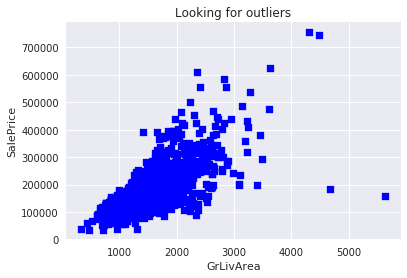

In [72]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train_data.GrLivArea, train_data.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train_data = train_data[train_data.GrLivArea < 4000]

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [73]:
# Log transform the target for official scoring
# https://stats.stackexchange.com/questions/145383/getting-negative-predicted-values-after-linear-regression
# Linear regression does not respect the bounds of 0. 
# It's linear, always and everywhere. It may not be appropriate for values that need 
# to be close to 0 but are strictly positive.

# One way to manage this, particularly in the case of price, is to use the natural log of price.
train_data.SalePrice = np.log1p(train_data.SalePrice)

## 4. Model, predict and solve

Now we are ready to train a model and predict the required solution. There are many predictive modelling algorithms to choose from. These include: Logistic Regression ...

Let's start from Logistig Regression

In [74]:
# OverallQual       0.800858
# GrLivAreaFull     0.720516
# GarageCars        0.649256
# TotalBsmtSF       0.646584
# GarageAreaFull    0.636964

features=['OverallQual', 'GrLivAreaFull', 'GarageCars', 'TotalBsmtSF', 'GarageAreaFull']

In [75]:
X_train = train_data.drop("SalePrice", axis=1)[features]
Y_train = train_data["SalePrice"]
X_test  = test_data.drop("Id", axis=1)[features].copy()
X_train.shape, Y_train.shape, X_test.shape

((1456, 5), (1456,), (1459, 5))

**1* Linear Regression without regularization**

In [76]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
lr.score(X_train, Y_train)

0.82595122282531941

/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


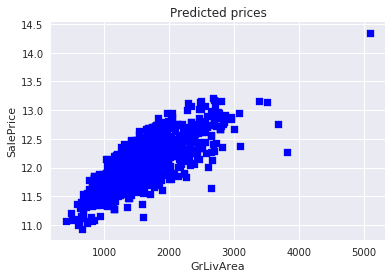

In [77]:
# Looking at the result
plt.scatter(X_test.GrLivAreaFull, Y_pred, c = "blue", marker = "s")
plt.title("Predicted prices")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

## 5. Printout the result

In [78]:
submission = pandas.DataFrame({
        "Id": test_data["Id"],
        "SalePrice": np.expm1(Y_pred)
    })
submission.to_csv('data/output.csv', index=False)